In [2]:
import torch
import torch.nn as nn
import torchvision as vision
from torchvision.transforms import Lambda,Compose,ToTensor,Normalize,Grayscale,ToPILImage
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

In [26]:
#transform=Compose([Grayscale(),ToTensor(),Normalize(0.5,0.5)])
transform=Compose([Grayscale(),ToTensor()])
dataset_train=datasets.ImageFolder("/kaggle/input/fer2013/train",transform=transform)
dataset_test=datasets.ImageFolder("/kaggle/input/fer2013/test",transform=transform)


In [27]:
print("There are {} samples each with the following categories \n {}".format(
      len(dataset_train),dataset_train.classes))

There are 28709 samples each with the following categories 
 ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


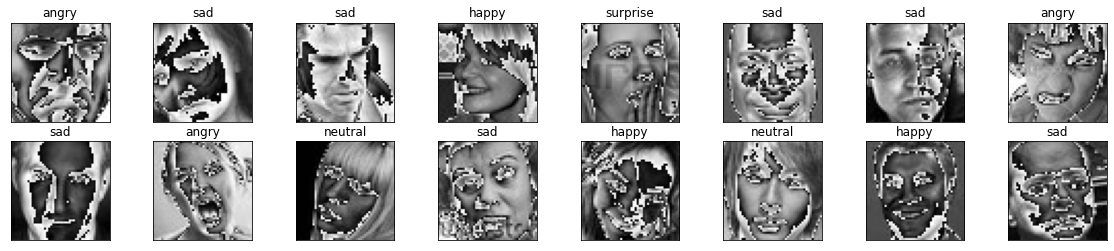

In [28]:


import matplotlib.pyplot as plt
fig=plt.figure(figsize=(20,4))
fig.tight_layout()
#plt.subplots_adjust( wspace=1, hspace=1)
to_image=ToPILImage()
for i in range(16):
            idx=torch.randint(len(dataset_test),size=(1,)).item()
            img,label=dataset_test[idx]
            t=fig.add_subplot(2,8,i+1)
            # set the title of the image equal to its label
            t.set_title(dataset_test.classes[label])
            t.axes.get_xaxis().set_visible(False)
            t.axes.get_yaxis().set_visible(False)
            plt.imshow(to_image(img),cmap='gray')

In [33]:
train_loader=DataLoader(dataset_train,batch_size=64,shuffle=True,num_workers=2,pin_memory=True)
test_loader=DataLoader(dataset_test,batch_size=64,shuffle=False,num_workers=2,pin_memory=True)

In [34]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu=nn.ReLU()
        self.flatten=nn.Flatten()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3)
        self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
        self.pool1=nn.MaxPool2d(kernel_size=2)
        self.drop1=nn.Dropout()
        self.conv3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3)
        self.conv4=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3)
        self.pool2=nn.MaxPool2d(kernel_size=2)
        self.drop2=nn.Dropout()
        self.fc1=nn.Linear(in_features=9*9*256,out_features=1024)
        self.drop3=nn.Dropout()
        self.fc2=nn.Linear(in_features=1024,out_features=7)
    def forward(self,x):
        #input (1,48,48)
        x=self.conv1(x)
        x=self.relu(x)
        #input (32,46,46)
        x=self.conv2(x)
        x=self.relu(x)
        #input (64,44,44)
        x=self.pool1(x)
        x=self.drop1(x)
        
        #input (64,22,22)
        x=self.conv3(x)
        x=self.relu(x)
        #input (128,20,20)
        x=self.conv4(x)
        x=self.relu(x)
        #input (256,18,18)
        x=self.pool2(x)
        x=self.drop2(x)
        #input (256,9,9)
        x=self.flatten(x)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.drop3(x)
        x=self.fc2(x)
        return x

In [35]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m,nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)
model=Net()
model=model.cuda()
#model.apply(init_weights)

In [36]:
%%time
import torch.optim as optim
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters())
from tqdm import tqdm
epochs=10

for epoch in range(epochs):
    print(f"epoch {epoch}:",end=' ')
    train_loader=tqdm(train_loader)
    epoch_loss=0.0
    for imgs,labels in train_loader:
        imgs=imgs.cuda()
        labels=labels.cuda()
        outputs=model(imgs)
        optimizer.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
    print(epoch_loss)
    
        

epoch 0: 

100%|██████████| 113/113 [00:18<00:00,  6.23it/s]


202.51928877830505
epoch 1: 

100%|██████████| 113/113 [00:22<00:00,  5.01it/s]


182.75911819934845
epoch 2: 

100%|██████████| 113/113 [00:20<00:00,  5.64it/s]


164.48150718212128
epoch 3: 

100%|██████████| 113/113 [00:19<00:00,  5.88it/s]


154.2722738981247
epoch 4: 

100%|██████████| 113/113 [00:19<00:00,  5.83it/s]


146.03134632110596
epoch 5: 

100%|██████████| 113/113 [00:18<00:00,  6.02it/s]


140.76830649375916
epoch 6: 

100%|██████████| 113/113 [00:18<00:00,  6.15it/s]


136.08606004714966
epoch 7: 

100%|██████████| 113/113 [00:18<00:00,  6.07it/s]


131.26216286420822
epoch 8: 

100%|██████████| 113/113 [00:18<00:00,  6.11it/s]


128.0280363559723
epoch 9: 

100%|██████████| 113/113 [00:18<00:00,  5.99it/s]

124.7220932841301
CPU times: user 48.1 s, sys: 4.34 s, total: 52.4 s
Wall time: 3min 12s


In [37]:
# save the model to a file
torch.save(model,'model.h5')

In [38]:
!pip install torchmetrics
from torchmetrics import ConfusionMatrix
conmat=ConfusionMatrix(num_classes=7)
conmat=conmat.cuda()

In [39]:
# load the model from the file
model=torch.load('model.h5')
total=len(dataset_test)
correct=0
for imgs,labels in test_loader:
    imgs=imgs.cuda()
    labels=labels.cuda()
    outputs=model(imgs)
    _,predicted=torch.max(outputs.data,1)
    tmp=(predicted==labels).sum()
    correct+=tmp
    conmat.update(predicted,labels)
print(correct/total)

tensor(0.5387, device='cuda:0')


In [24]:
import matplotlib.pyplot as plt
import seaborn as sb

<AxesSubplot:>

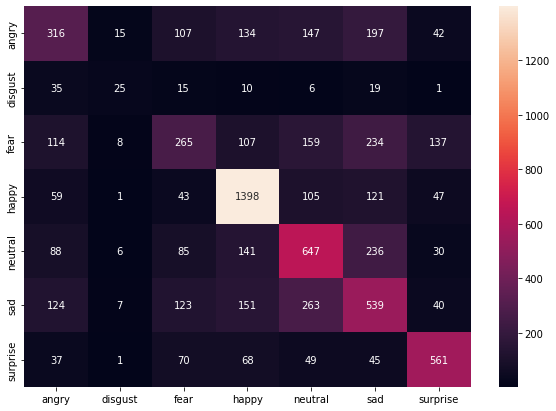

In [25]:
x=conmat.compute().cpu().numpy()
plt.figure(figsize=(10,7))
sb.heatmap(x,xticklabels=dataset_train.classes,yticklabels=dataset_train.classes,annot=True,fmt=".0f")